In [1]:
# Built-in
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, GlobalAveragePooling2D, LSTM, Dense, Dropout
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)


In [2]:
import tensorflow as tf

print("Các thiết bị có sẵn:")
print(tf.config.list_physical_devices())

if tf.config.list_physical_devices('GPU'):
    print("✅ Đang sử dụng GPU")
else:
    print("🚫 Không có GPU, đang dùng CPU")

Các thiết bị có sẵn:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Đang sử dụng GPU


In [3]:
# Define the path to the dataset
base_path = '/Users/admin/AIEngineer/DeepFakeProject/Dataset/Faceplus2'
categories = ['fake', 'real']

# Initialize a list to hold data
data = []

# Process each category
for category in categories:
    category_path = os.path.join(base_path, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.jpg'):
            try:
                id_part, frame_part = filename.split('_frame_')
                id_ = id_part.split('_')[0]
                frame = frame_part.split('.')[0]
                data.append({
                    'filename': filename,
                    'path': os.path.join(category_path, filename),
                    'id': int(id_),
                    'frame': int(frame),
                    'label': category
                })
            except ValueError:
                continue

# Convert the data to a DataFrame
df = pd.DataFrame(data)

In [4]:
# Đảm bảo đã có df_cropped.csv chứa đường dẫn ảnh đã crop
df['label_id'] = df['label'].map({'fake': 0, 'real': 1})
df


,filename,path,id,frame,label,label_id
0,596_609_frame_0019.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,596,19,fake,0
1,746_571_frame_0008.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,746,8,fake,0
2,514_443_frame_0028.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,514,28,fake,0
3,642_635_frame_0006.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,642,6,fake,0
4,937_888_frame_0009.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,937,9,fake,0
...,...,...,...,...,...,...
59803,727_frame_0009.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,727,9,real,1
59804,832_frame_0026.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,832,26,real,1
59805,059_frame_0005.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,59,5,real,1
59806,572_frame_0008.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,572,8,real,1


In [5]:
df['video_key'] = df['id'].astype(str) + "_" + df['label']

from collections import defaultdict

video_dict = defaultdict(list)
labels = {}

for _, row in df.iterrows():
    key = row['video_key']
    video_dict[key].append(row['path'])
    labels[key] = row['label_id']


In [6]:
labels 


{'596_fake': 0,
 '746_fake': 0,
 '514_fake': 0,
 '642_fake': 0,
 '937_fake': 0,
 '0_fake': 0,
 '241_fake': 0,
 '174_fake': 0,
 '308_fake': 0,
 '348_fake': 0,
 '793_fake': 0,
 '961_fake': 0,
 '991_fake': 0,
 '653_fake': 0,
 '341_fake': 0,
 '304_fake': 0,
 '687_fake': 0,
 '719_fake': 0,
 '90_fake': 0,
 '38_fake': 0,
 '827_fake': 0,
 '605_fake': 0,
 '454_fake': 0,
 '244_fake': 0,
 '418_fake': 0,
 '4_fake': 0,
 '538_fake': 0,
 '79_fake': 0,
 '128_fake': 0,
 '146_fake': 0,
 '766_fake': 0,
 '155_fake': 0,
 '579_fake': 0,
 '581_fake': 0,
 '692_fake': 0,
 '580_fake': 0,
 '898_fake': 0,
 '641_fake': 0,
 '171_fake': 0,
 '737_fake': 0,
 '832_fake': 0,
 '337_fake': 0,
 '510_fake': 0,
 '879_fake': 0,
 '408_fake': 0,
 '143_fake': 0,
 '487_fake': 0,
 '865_fake': 0,
 '73_fake': 0,
 '682_fake': 0,
 '287_fake': 0,
 '743_fake': 0,
 '922_fake': 0,
 '407_fake': 0,
 '133_fake': 0,
 '850_fake': 0,
 '234_fake': 0,
 '478_fake': 0,
 '325_fake': 0,
 '840_fake': 0,
 '886_fake': 0,
 '611_fake': 0,
 '125_fake': 0,


In [7]:
!pip install opencv-python

In [8]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dropout, Dense, GlobalAveragePooling2D, BatchNormalization, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from hmmlearn.hmm import GaussianHMM
from scipy.stats import mode

# Giả định đã có
video_keys = list(video_dict.keys())
video_labels = [labels[k] for k in video_keys]

img_size = (224, 224)
batch_size = 16
epochs = 50
n_splits = 5
sequence_len = 10
results = []
all_histories = []

# Data generator
class VideoSequence(tf.keras.utils.Sequence):
    def __init__(self, video_keys, video_dict, labels, batch_size, img_size, sequence_len=10, augment=False):
        self.video_keys = video_keys
        self.video_dict = video_dict
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.sequence_len = sequence_len
        self.augment = augment
        self.datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15 if augment else 0,
            zoom_range=0.1 if augment else 0,
            horizontal_flip=augment
        )

    def __len__(self):
        return int(np.ceil(len(self.video_keys) / self.batch_size))

    def __getitem__(self, idx):
        batch_keys = self.video_keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X, batch_y = [], []

        for key in batch_keys:
            frames = self.video_dict[key][:self.sequence_len]
            imgs = []
            for path in frames:
                img = cv2.imread(path)
                img = cv2.resize(img, self.img_size)
                img = self.datagen.random_transform(img) if self.augment else img
                img = img.astype('float32') / 255.0
                imgs.append(img)
            while len(imgs) < self.sequence_len:
                imgs.append(np.zeros((*self.img_size, 3), dtype='float32'))
            batch_X.append(imgs)
            batch_y.append(self.labels[key])

        return np.array(batch_X), np.array(batch_y)

# Build model cải tiến
def build_model(sequence_len, img_size):
    base_cnn = MobileNetV2(input_shape=(*img_size, 3), include_top=False, weights='imagenet')

    # Freeze toàn bộ backbone để giảm overfit
    base_cnn.trainable = False

    # CNN feature extractor
    cnn_out = GlobalAveragePooling2D()(base_cnn.output)
    cnn_model = Model(inputs=base_cnn.input, outputs=cnn_out)

    # Sequence input
    input_seq = Input(shape=(sequence_len, *img_size, 3))
    x = TimeDistributed(cnn_model)(input_seq)

    # LSTM đơn giản hơn
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.5)(x)

    # Không dùng nhiều Dense, chỉ một đầu ra
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_seq, outputs=output)
    return model

# HMM cải tiến
def hmm_postprocess(pred_probs, y_true, n_states=2):
    pred_probs = pred_probs.reshape(-1, 1)
    hmm = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
    hmm.fit(pred_probs)
    hidden_states = hmm.predict(pred_probs)

    mapping = {}
    for state in np.unique(hidden_states):
        indices = [i for i in range(len(hidden_states)) if hidden_states[i] == state]
        state_labels = [y_true[i] for i in indices]
        if len(state_labels) > 0:
            mapped_label = mode(state_labels, keepdims=True).mode[0]
        else:
            mapped_label = 0  # fallback
        mapping[state] = mapped_label

    hmm_labels = np.array([mapping[s] for s in hidden_states])
    return hmm_labels

# Training K-Fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (trainval_idx, test_idx) in enumerate(skf.split(video_keys, video_labels), 1):
    print(f"\n===== Fold {fold} =====")

    trainval_keys = [video_keys[i] for i in trainval_idx]
    test_keys = [video_keys[i] for i in test_idx]

    y_trainval = [labels[k] for k in trainval_keys]
    train_keys, val_keys = train_test_split(trainval_keys, test_size=0.1, stratify=y_trainval, random_state=fold)

    train_gen = VideoSequence(train_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=True)
    val_gen = VideoSequence(val_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)
    test_gen = VideoSequence(test_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)

    model = build_model(sequence_len, img_size)
    model.compile(optimizer=Adamax(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    model_path = f"best_model_fold{fold}.h5"
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    earlystop = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs,
                        callbacks=[checkpoint, earlystop, reduce_lr], verbose=1)
    all_histories.append(history.history)

    model.load_weights(model_path)

    y_true = [labels[k] for k in test_keys]
    y_pred_prob = model.predict(test_gen).ravel()
    y_hmm_pred = hmm_postprocess(y_pred_prob, y_true)

    results.append({
        'fold': fold,
        'accuracy': accuracy_score(y_true, y_hmm_pred),
        'precision': precision_score(y_true, y_hmm_pred),
        'recall': recall_score(y_true, y_hmm_pred),
        'f1': f1_score(y_true, y_hmm_pred),
        'auc': roc_auc_score(y_true, y_pred_prob)
    })

print("\n📊 Tổng kết kết quả các fold:")
for r in results:
    print(f"Fold {r['fold']}: Accuracy={r['accuracy']:.4f}, F1={r['f1']:.4f}, AUC={r['auc']:.4f}")



===== Fold 1 =====


2025-08-02 18:45:57.337283: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-08-02 18:45:57.337313: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-08-02 18:45:57.337321: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-08-02 18:45:57.337512: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-02 18:45:57.337703: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2025-08-02 18:45:59.942657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


90/90 [==============================] - ETA: 0s - loss: 0.7294 - accuracy: 0.5333  
Epoch 1: val_accuracy improved from -inf to 0.56875, saving model to best_model_fold1.h5


/opt/anaconda3/envs/environment_tf_216/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 52s 557ms/step - loss: 0.7294 - accuracy: 0.5333 - val_loss: 0.6843 - val_accuracy: 0.5688 - lr: 1.0000e-04
Epoch 2/50
90/90 [==============================] - ETA: 0s - loss: 0.6643 - accuracy: 0.6104  
Epoch 2: val_accuracy improved from 0.56875 to 0.61250, saving model to best_model_fold1.h5
90/90 [==============================] - 48s 530ms/step - loss: 0.6643 - accuracy: 0.6104 - val_loss: 0.6627 - val_accuracy: 0.6125 - lr: 1.0000e-04
Epoch 3/50
90/90 [==============================] - ETA: 0s - loss: 0.6303 - accuracy: 0.6590  
Epoch 3: val_accuracy improved from 0.61250 to 0.61875, saving model to best_model_fold1.h5
90/90 [==============================] - 51s 562ms/step - loss: 0.6303 - accuracy: 0.6590 - val_loss: 0.6449 - val_accuracy: 0.6187 - lr: 1.0000e-04
Epoch 4/50
90/90 [==============================] - ETA: 0s - loss: 0.6032 - accuracy: 0.6924  
Epoch 4: val_accuracy improved from 0.61875 to 0.65625, saving model to best_mode

Epoch 1/50
90/90 [==============================] - ETA: 0s - loss: 0.6864 - accuracy: 0.5479  
Epoch 1: val_accuracy improved from -inf to 0.61250, saving model to best_model_fold2.h5


/opt/anaconda3/envs/environment_tf_216/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 50s 535ms/step - loss: 0.6864 - accuracy: 0.5479 - val_loss: 0.6667 - val_accuracy: 0.6125 - lr: 1.0000e-04
Epoch 2/50
90/90 [==============================] - ETA: 0s - loss: 0.6536 - accuracy: 0.6042  
Epoch 2: val_accuracy did not improve from 0.61250
90/90 [==============================] - 67s 748ms/step - loss: 0.6536 - accuracy: 0.6042 - val_loss: 0.6454 - val_accuracy: 0.6125 - lr: 1.0000e-04
Epoch 3/50
90/90 [==============================] - ETA: 0s - loss: 0.6268 - accuracy: 0.6556  
Epoch 3: val_accuracy improved from 0.61250 to 0.65625, saving model to best_model_fold2.h5
90/90 [==============================] - 59s 651ms/step - loss: 0.6268 - accuracy: 0.6556 - val_loss: 0.6301 - val_accuracy: 0.6562 - lr: 1.0000e-04
Epoch 4/50
90/90 [==============================] - ETA: 0s - loss: 0.6074 - accuracy: 0.6854  
Epoch 4: val_accuracy improved from 0.65625 to 0.66875, saving model to best_model_fold2.h5
90/90 [=======================

Epoch 1/50
90/90 [==============================] - ETA: 0s - loss: 0.6945 - accuracy: 0.5618  
Epoch 1: val_accuracy improved from -inf to 0.57500, saving model to best_model_fold3.h5


/opt/anaconda3/envs/environment_tf_216/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 50s 526ms/step - loss: 0.6945 - accuracy: 0.5618 - val_loss: 0.6841 - val_accuracy: 0.5750 - lr: 1.0000e-04
Epoch 2/50
90/90 [==============================] - ETA: 0s - loss: 0.6444 - accuracy: 0.6271  
Epoch 2: val_accuracy improved from 0.57500 to 0.62500, saving model to best_model_fold3.h5
90/90 [==============================] - 47s 518ms/step - loss: 0.6444 - accuracy: 0.6271 - val_loss: 0.6583 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 3/50
90/90 [==============================] - ETA: 0s - loss: 0.6096 - accuracy: 0.6611  
Epoch 3: val_accuracy improved from 0.62500 to 0.65000, saving model to best_model_fold3.h5
90/90 [==============================] - 48s 528ms/step - loss: 0.6096 - accuracy: 0.6611 - val_loss: 0.6425 - val_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 4/50
90/90 [==============================] - ETA: 0s - loss: 0.5790 - accuracy: 0.7035  
Epoch 4: val_accuracy did not improve from 0.65000
90/90 [=======================

Epoch 1/50
90/90 [==============================] - ETA: 0s - loss: 0.6952 - accuracy: 0.5542  
Epoch 1: val_accuracy improved from -inf to 0.58125, saving model to best_model_fold4.h5


/opt/anaconda3/envs/environment_tf_216/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 49s 521ms/step - loss: 0.6952 - accuracy: 0.5542 - val_loss: 0.6818 - val_accuracy: 0.5813 - lr: 1.0000e-04
Epoch 2/50
90/90 [==============================] - ETA: 0s - loss: 0.6559 - accuracy: 0.6201  
Epoch 2: val_accuracy did not improve from 0.58125
90/90 [==============================] - 47s 517ms/step - loss: 0.6559 - accuracy: 0.6201 - val_loss: 0.6669 - val_accuracy: 0.5813 - lr: 1.0000e-04
Epoch 3/50
90/90 [==============================] - ETA: 0s - loss: 0.6282 - accuracy: 0.6632  
Epoch 3: val_accuracy improved from 0.58125 to 0.61250, saving model to best_model_fold4.h5
90/90 [==============================] - 47s 518ms/step - loss: 0.6282 - accuracy: 0.6632 - val_loss: 0.6505 - val_accuracy: 0.6125 - lr: 1.0000e-04
Epoch 4/50
90/90 [==============================] - ETA: 0s - loss: 0.6028 - accuracy: 0.6729  
Epoch 4: val_accuracy improved from 0.61250 to 0.63125, saving model to best_model_fold4.h5
90/90 [=======================

/opt/anaconda3/envs/environment_tf_216/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



===== Fold 5 =====


Epoch 1/50
90/90 [==============================] - ETA: 0s - loss: 0.6774 - accuracy: 0.5826  
Epoch 1: val_accuracy improved from -inf to 0.56875, saving model to best_model_fold5.h5


/opt/anaconda3/envs/environment_tf_216/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 93s 1s/step - loss: 0.6774 - accuracy: 0.5826 - val_loss: 0.6579 - val_accuracy: 0.5688 - lr: 1.0000e-04
Epoch 2/50
90/90 [==============================] - ETA: 0s - loss: 0.6261 - accuracy: 0.6458  
Epoch 2: val_accuracy improved from 0.56875 to 0.62500, saving model to best_model_fold5.h5
90/90 [==============================] - 61s 673ms/step - loss: 0.6261 - accuracy: 0.6458 - val_loss: 0.6321 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 3/50
90/90 [==============================] - ETA: 0s - loss: 0.5971 - accuracy: 0.6896  
Epoch 3: val_accuracy improved from 0.62500 to 0.63750, saving model to best_model_fold5.h5
90/90 [==============================] - 51s 569ms/step - loss: 0.5971 - accuracy: 0.6896 - val_loss: 0.6110 - val_accuracy: 0.6375 - lr: 1.0000e-04
Epoch 4/50
90/90 [==============================] - ETA: 0s - loss: 0.5749 - accuracy: 0.6958  
Epoch 4: val_accuracy improved from 0.63750 to 0.66875, saving model to best_model_f

In [9]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.830500
precision    0.749251
recall       0.697000
f1           0.715867
auc          0.781600
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.9975,1.000000,0.995,0.997494,0.765675
1,2,0.9725,0.947867,1.000,0.973236,0.796625
2,3,0.9975,1.000000,0.995,0.997494,0.794600
3,4,0.5000,0.000000,0.000,0.000000,0.782500
4,5,0.6850,0.798387,0.495,0.611111,0.768600


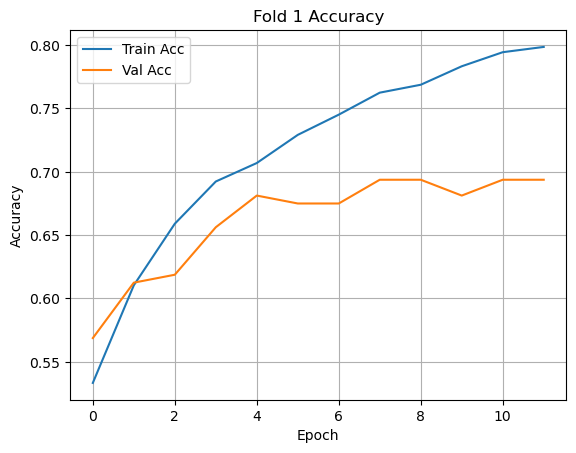

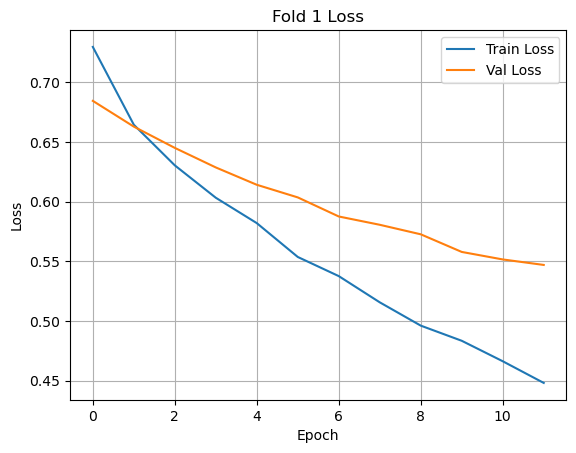

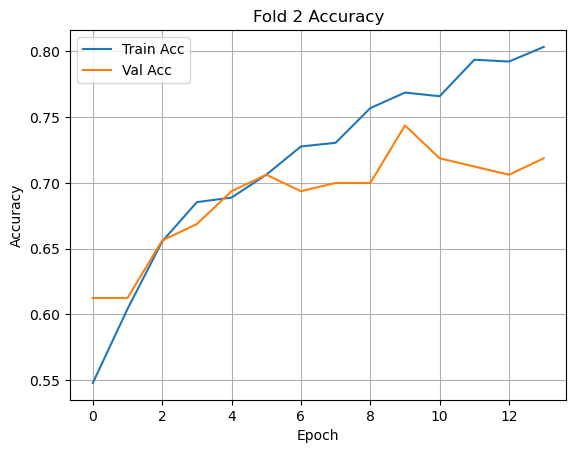

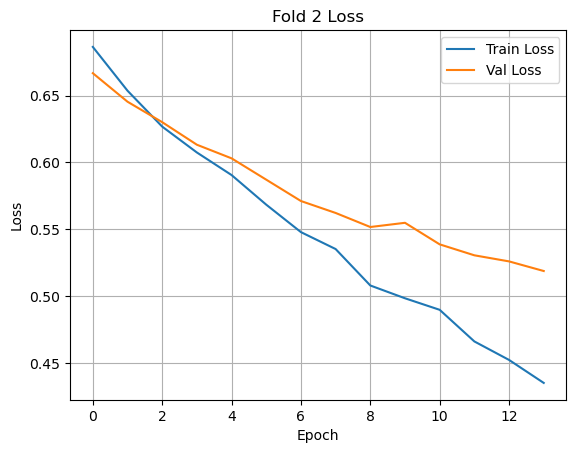

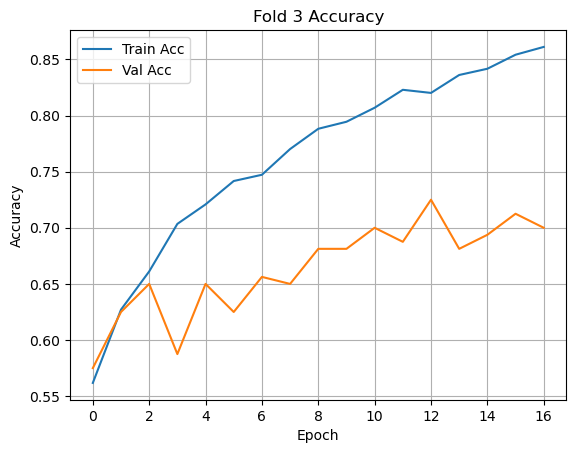

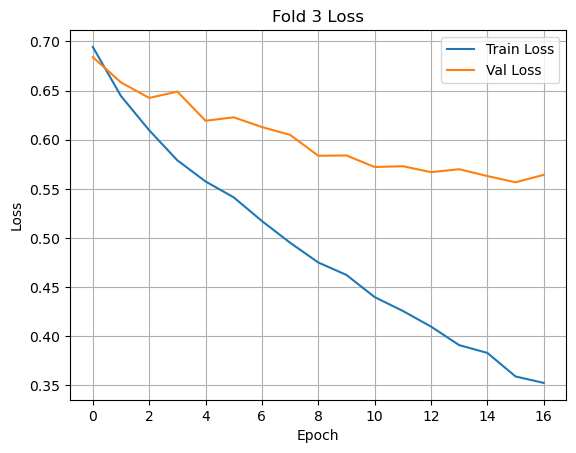

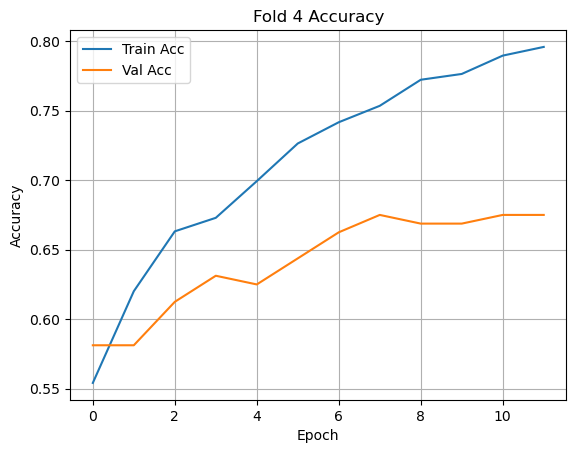

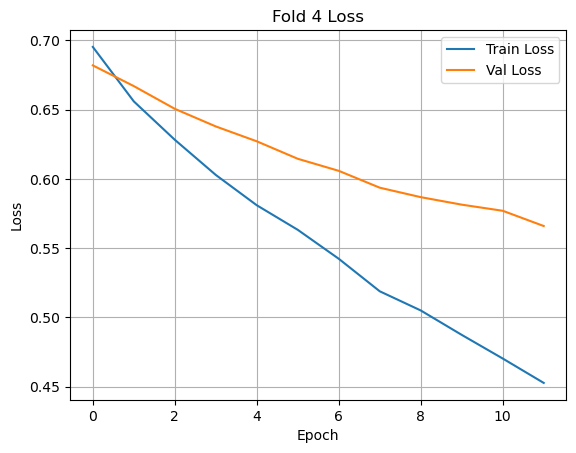

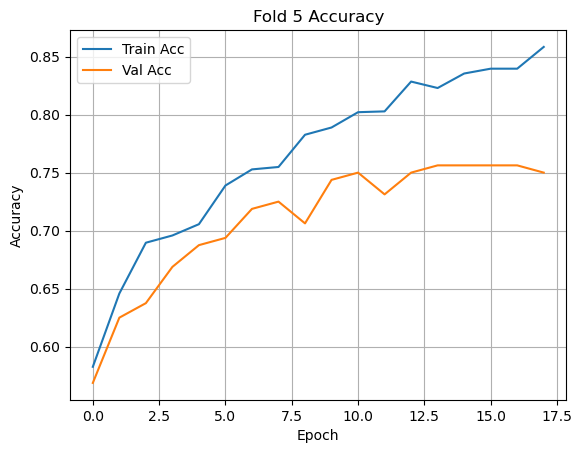

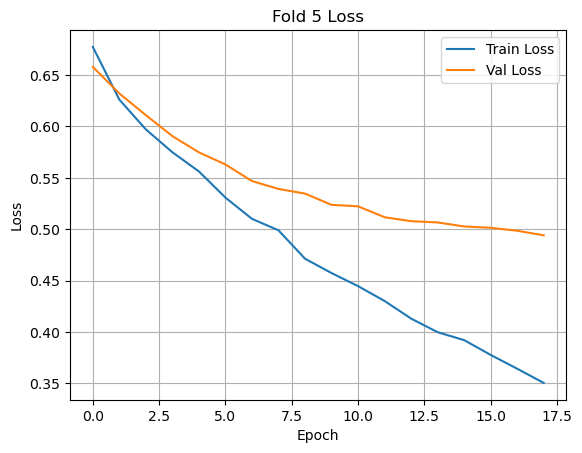

In [10]:
for i, hist in enumerate(all_histories, 1):
    plt.figure()
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [11]:
# Save mô hình fold cuối cùng
model.save("mobilenetv2_hmm_faceplus_final.h5")


/opt/anaconda3/envs/environment_tf_216/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
import pandas as pd

# Giả sử results đã có và bạn đã tạo results_df
results_df = pd.DataFrame(results)

# Tính các chỉ số
accuracy_mean = results_df['accuracy'].mean()
accuracy_std = results_df['accuracy'].std()  # dùng sample std (chia cho n-1)
accuracy_range = results_df['accuracy'].max() - results_df['accuracy'].min()
accuracy_cv_percent = (accuracy_std / accuracy_mean) * 100

# In kết quả
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))

print(f"\n✅ CV Accuracy (Mean Accuracy): {accuracy_mean:.4f}")
print(f"📈 Range Accuracy: {accuracy_range:.4f}")
print(f"📉 Accuracy CV% (std/mean): {accuracy_cv_percent:.2f}%")

# Hiển thị bảng kết quả nếu cần
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.830500
precision    0.749251
recall       0.697000
f1           0.715867
auc          0.781600
dtype: float64

✅ CV Accuracy (Mean Accuracy): 0.8305
📈 Range Accuracy: 0.4975
📉 Accuracy CV% (std/mean): 27.35%


,fold,accuracy,precision,recall,f1,auc
0,1,0.9975,1.000000,0.995,0.997494,0.765675
1,2,0.9725,0.947867,1.000,0.973236,0.796625
2,3,0.9975,1.000000,0.995,0.997494,0.794600
3,4,0.5000,0.000000,0.000,0.000000,0.782500
4,5,0.6850,0.798387,0.495,0.611111,0.768600
